# 基于 Keras Applications 的预训练模型在隐语联邦学习环境下的微调
## 引言
预训练模型加载和精调在机器学习中非常重要。一般来说，从头训练一个非常大的模型，不仅需要大量的算力资源，同时也需要耗费大量的时间。所以在传统的机器学习中，使用预训练模型，然后针对具体的任务做微调和迁移学习非常普遍。同样的，对于联邦学习来说，如果能够加载预训练模型进行微调和迁移学习，不仅能够节省参与方的算力资源，降低参与方的准入门槛，同时也能够加快模型的学习速度。

得益于隐语联邦学习模块优异的兼容性，使得其可以直接加载TensorFlow.Keras的一系列[预训练模型](https://keras.io/api/applications/)；本教程将基于TensorFlow.Keras的[InceptionV3](https://arxiv.org/abs/1512.00567)的[微调教程](https://keras.io/api/applications/#finetune-inceptionv3-on-a-new-set-of-classes)展现如何基于TensorFlow.Keras的预训练模型在SecretFlow的框架下进行微调，充分展现SecretFlow的易用性。

## 加载数据集
### 数据集介绍
Flower 数据集介绍：flower 数据集是一个包含了 5 种花卉（雏菊、蒲公英、玫瑰、向日葵、郁金香）共计 4323 张彩色图片的数据集。每种花卉都有多个角度和不同光照下的图片，每张图片的分辨率为 320x240。这个数据集常用于图像分类和机器学习算法的训练与测试。数据集中每个类别的数量分别是：daisy（633），dandelion（898），rose（641），sunflower（699），tulip（852）

下载地址: http://download.tensorflow.org/example_images/flower_photos.tgz

### 下载数据集并解压

In [ ]:
import tempfile
import tensorflow as tf


_temp_dir = tempfile.mkdtemp()
path_to_flower_dataset = tf.keras.utils.get_file(
    "flower_photos",
    "https://secretflow-data.oss-accelerate.aliyuncs.com/datasets/tf_flowers/flower_photos.tgz",
    untar=True,
    cache_dir=_temp_dir,
)

2023-10-11 07:11:54.892985: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 07:11:55.019580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 07:11:57.008960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


67588319/67588319 [==============================] - 2s 0us/step


### 加载数据集

In [ ]:
import math
import tensorflow as tf

img_height = 180
img_width = 180
batch_size = 32
# In this example, we use the TensorFlow interface for development.
data_set = tf.keras.utils.image_dataset_from_directory(
    path_to_flower_dataset,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 1201 files belonging to 5 classes.
Using 961 files for training.
Using 240 files for validation.


2023-10-11 07:12:05.321890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12653 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-10-11 07:12:05.324020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13775 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:3c:00.0, compute capability: 7.5


### 划分数据集

In [ ]:
train_set = data_set[0]
test_set = data_set[1]

### 查看数据集


In [ ]:
print(type(train_set), type(test_set))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [ ]:
x, y = next(iter(train_set))
print(f"x.shape = {x.shape}")
print(f"y.shape = {y.shape}")

## 单机模式进行微调
单机模式下进行预训练模型的微调，基本上参考TensorFlow.Keras的[官方教程](https://keras.io/api/applications/#finetune-inceptionv3-on-a-new-set-of-classes)，并根据数据集格式在编译模型的参数上作适当的修改，但影响不大；

### 微调顶部分类器

In [ ]:
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
)

In [ ]:
# train the model on the new data for a few epochs
history = model.fit(train_set, validation_data=test_set, epochs=50)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

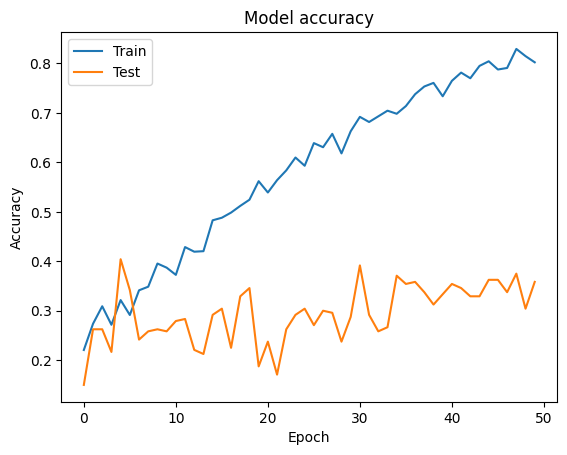

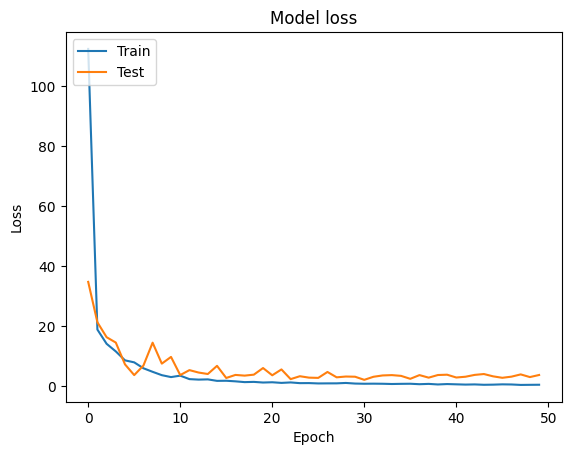

In [ ]:
# Draw accuracy values for training & validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 冻结底层网络层微调顶层网络层

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD

model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
)

In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(train_set, validation_data=test_set, epochs=50)

Epoch 1/50
31/31 [==============================] - 13s 118ms/step - loss: 1.7043 - accuracy: 0.2882 - val_loss: 1.6911 - val_accuracy: 0.3458
Epoch 2/50
31/31 [==============================] - 2s 71ms/step - loss: 1.6528 - accuracy: 0.3330 - val_loss: 1.6635 - val_accuracy: 0.3375
Epoch 3/50
31/31 [==============================] - 2s 70ms/step - loss: 1.6001 - accuracy: 0.3673 - val_loss: 1.6358 - val_accuracy: 0.3250
Epoch 4/50
31/31 [==============================] - 2s 71ms/step - loss: 1.5633 - accuracy: 0.3975 - val_loss: 1.6324 - val_accuracy: 0.3208
Epoch 5/50
31/31 [==============================] - 2s 71ms/step - loss: 1.5255 - accuracy: 0.3975 - val_loss: 1.6274 - val_accuracy: 0.3250
Epoch 6/50
31/31 [==============================] - 2s 71ms/step - loss: 1.4992 - accuracy: 0.4048 - val_loss: 1.6040 - val_accuracy: 0.3167
Epoch 7/50
31/31 [==============================] - 2s 71ms/step - loss: 1.4658 - accuracy: 0.4287 - val_loss: 1.5823 - val_accuracy: 0.3292
Epoch 8/50


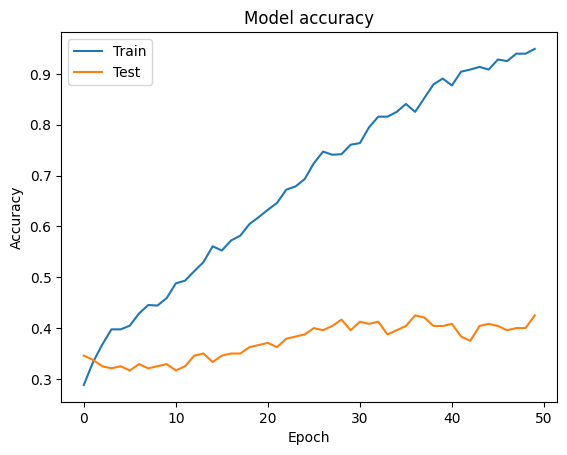

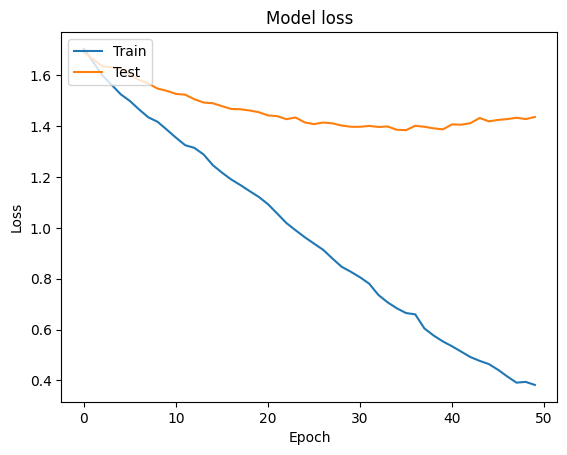

In [ ]:
# Draw accuracy values for training & validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 单机模式小结
以上我们按照官方教程在数据集Flower 上成功微调了 InceptionV3 模型，分别是**微调顶部分类器**和**冻结底层网络层微调顶层网络层**。接下来我们将展示如何将单机模式下的微调拓展到联邦学习模式下进行微调。

## 联邦学习模式进行微调

### 环境设置
首先我们初始化各个参与方。

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20230926


2023-10-11 07:16:09,152	INFO worker.py:1538 -- Started a local Ray instance.


### 定义Dataloader
我们可以参考[TensorFlow下的DataBuilder教程](https://www.secretflow.org.cn/docs/secretflow/latest/zh-Hans/tutorial/CustomDataLoaderTF)定义我们自己的DataBuilder。

In [ ]:
def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(folder_path, stage="train"):
        import math

        import tensorflow as tf

        img_height = 180
        img_width = 180
        data_set = tf.keras.utils.image_dataset_from_directory(
            folder_path,
            validation_split=0.2,
            subset="both",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size,
        )
        if stage == "train":
            train_dataset = data_set[0]
            train_step_per_epoch = math.ceil(len(data_set[0].file_paths) / batch_size)
            return train_dataset, train_step_per_epoch
        elif stage == "eval":
            eval_dataset = data_set[1]
            eval_step_per_epoch = math.ceil(len(data_set[1].file_paths) / batch_size)
            return eval_dataset, eval_step_per_epoch

    return dataset_builder

In [ ]:
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
    ),
    bob: create_dataset_builder(
        batch_size=32,
    ),
}

### 定义 SecureAggregator

In [ ]:
from secretflow_fl.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator

device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.


### 定义数据加载路径
为了简便起见，我们在 单机模拟模式下直接加载同一处路径所对应的数据集

In [ ]:
data = {
    alice: path_to_flower_dataset,
    bob: path_to_flower_dataset,
}

### 定义联邦学习训练参数

In [ ]:
epochs = 50
batch_size = 32
aggregate_freq = 2
sampler_method = "batch"
random_seed = 1234
dp_spent_step_freq = 1

### 微调顶部分类器
我们只要参照教程里对模型的定义，在函数里完成我们对模型的定义即可；可以看到代码几乎不需要作任何修改，只需要进行适当的封装。
为了方便作对比实验，我们额外添加是否加载权重的选项。

In [ ]:
def create_inception_v3_model_classifier(num_classes, is_load_weight=True):
    def create_model():
        from tensorflow import keras

        # Create model
        # create the base pre-trained model
        if is_load_weight:
            base_model = InceptionV3(weights='imagenet', include_top=False)
        else:
            base_model = InceptionV3(weights=None, include_top=False)

        # add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        # let's add a fully-connected layer
        x = Dense(1024, activation='relu')(x)
        # and a logistic layer -- let's say we have 10 classes
        predictions = Dense(num_classes, activation='softmax')(x)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)

        # first: train only the top layers (which were randomly initialized)
        # i.e. freeze all convolutional InceptionV3 layers
        for layer in base_model.layers:
            layer.trainable = False

        # Compile model
        model.compile(
            optimizer='rmsprop',
            loss='sparse_categorical_crossentropy',
            metrics=["accuracy"],
        )

        return model

    return create_model

#### 加载预训练模型权重并且微调

In [ ]:
# prepare model
num_classes = 5

# keras model
weight_model = create_inception_v3_model_classifier(
    num_classes=num_classes, is_load_weight=True
)


fed_model = FLModel(
    device_list=device_list,
    model=weight_model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [ ]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=epochs,
    batch_size=batch_size,
    aggregate_freq=aggregate_freq,
    sampler_method=sampler_method,
    random_seed=random_seed,
    dp_spent_step_freq=dp_spent_step_freq,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'self': <secretflow_fl.ml.nn.fl.fl_model.FLModel object at 0x7fbd4bb1cb50>, 'x': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 50, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbb907ee700>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbadc0d5040>}, 'wait_steps': 100}
32it [0

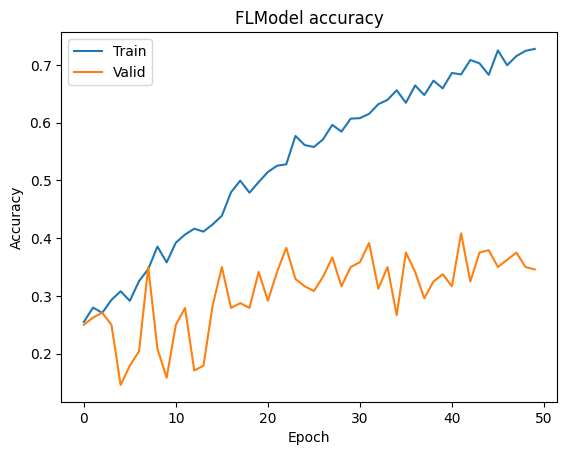

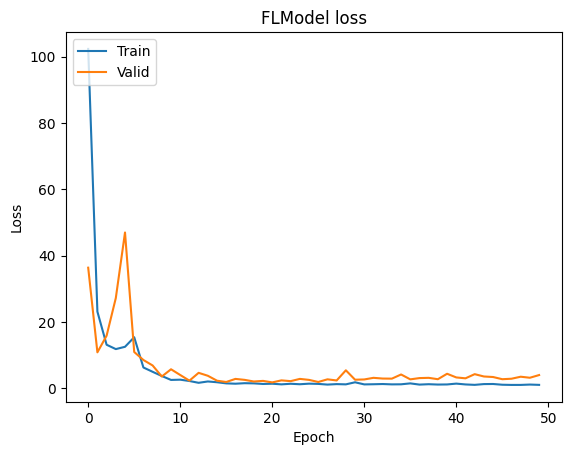

In [ ]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['accuracy'])
plt.plot(history.global_history['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

#### 只加载网络结构同时随机初始化

In [ ]:
# keras model
no_weight_model = create_inception_v3_model_classifier(
    num_classes=num_classes, is_load_weight=False
)


fed_model = FLModel(
    device_list=device_list,
    model=no_weight_model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [ ]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=epochs,
    batch_size=batch_size,
    aggregate_freq=aggregate_freq,
    sampler_method=sampler_method,
    random_seed=random_seed,
    dp_spent_step_freq=dp_spent_step_freq,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'self': <secretflow_fl.ml.nn.fl.fl_model.FLModel object at 0x7fbd4baefbe0>, 'x': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 50, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbb907ee700>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbadc0d5040>}, 'wait_steps': 100}
32it [0

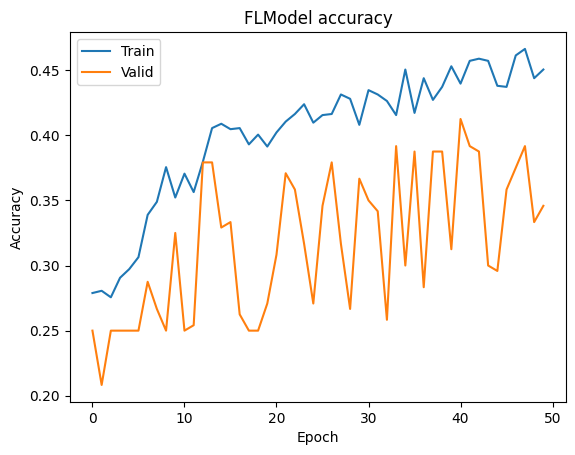

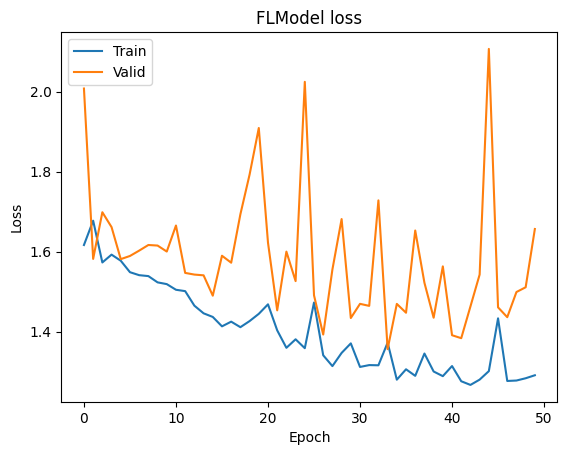

In [ ]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['accuracy'])
plt.plot(history.global_history['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### 冻结底层微调顶层网络
我们只要参照教程里对模型的定义，在函数里完成我们对模型的定义即可；可以看到代码几乎不需要作任何修改，只需要进行适当的封装。
为了方便作对比实验，我们额外添加是否加载权重的选项。

In [ ]:
def create_inception_v3_model_fine_tune(num_classes, is_load_weight=True):
    def create_model():
        from tensorflow import keras

        # Create model
        # create the base pre-trained model
        if is_load_weight:
            base_model = InceptionV3(weights='imagenet', include_top=False)
        else:
            base_model = InceptionV3(weights=None, include_top=False)

        # add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        # let's add a fully-connected layer
        x = Dense(1024, activation='relu')(x)
        # and a logistic layer -- let's say we have 10 classes
        predictions = Dense(num_classes, activation='softmax')(x)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)

        for layer in model.layers[:249]:
            layer.trainable = False
        for layer in model.layers[249:]:
            layer.trainable = True

        # Compile model
        model.compile(
            optimizer=SGD(learning_rate=0.0001, momentum=0.9),
            loss='sparse_categorical_crossentropy',
            metrics=["accuracy"],
        )

        return model

    return create_model

#### 加载预训练模型权重并且微调

In [ ]:
# keras model
weight_model = create_inception_v3_model_fine_tune(
    num_classes=num_classes, is_load_weight=True
)


fed_model = FLModel(
    device_list=device_list,
    model=weight_model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [ ]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=epochs,
    batch_size=batch_size,
    aggregate_freq=aggregate_freq,
    sampler_method=sampler_method,
    random_seed=random_seed,
    dp_spent_step_freq=dp_spent_step_freq,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'self': <secretflow_fl.ml.nn.fl.fl_model.FLModel object at 0x7fbc1c65c160>, 'x': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 50, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbb907ee700>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbadc0d5040>}, 'wait_steps': 100}
32it [0

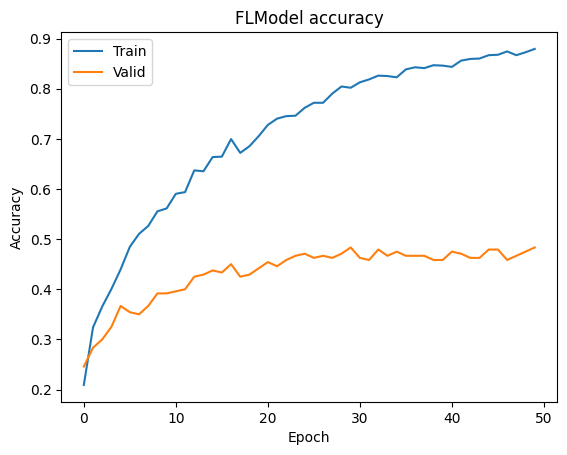

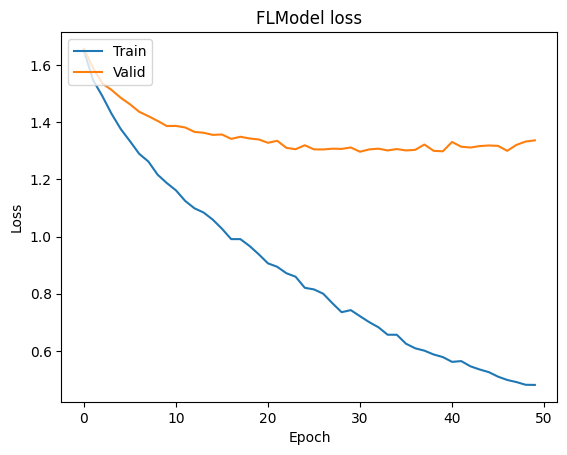

In [ ]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['accuracy'])
plt.plot(history.global_history['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

#### 只加载网络结构同时随机初始化

In [ ]:
# keras model
no_weight_model = create_inception_v3_model_fine_tune(
    num_classes=num_classes, is_load_weight=False
)


fed_model = FLModel(
    device_list=device_list,
    model=no_weight_model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow_fl.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [ ]:
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=epochs,
    batch_size=batch_size,
    aggregate_freq=aggregate_freq,
    sampler_method=sampler_method,
    random_seed=random_seed,
    dp_spent_step_freq=dp_spent_step_freq,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'self': <secretflow_fl.ml.nn.fl.fl_model.FLModel object at 0x7fbc24074700>, 'x': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 50, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): '/tmp/tmpc7wdf9us/datasets/flower_photos', PYURuntime(bob): '/tmp/tmpc7wdf9us/datasets/flower_photos'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbb907ee700>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbadc0d5040>}, 'wait_steps': 100}
32it [0

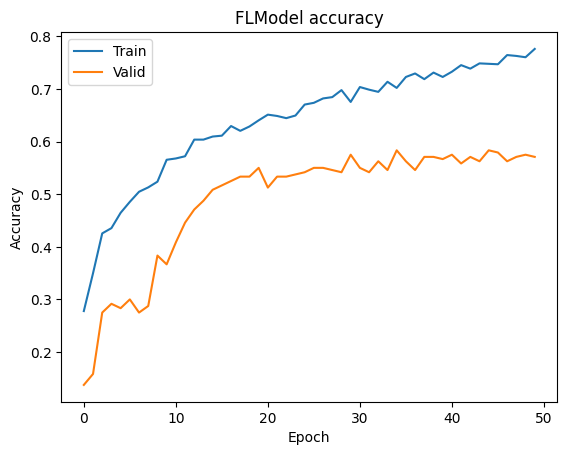

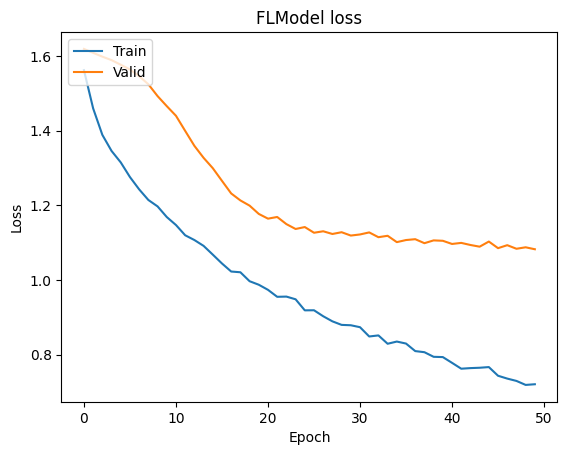

In [ ]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['accuracy'])
plt.plot(history.global_history['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

### 联邦学习小结
可以看到，对照着 TensorFlow 的官方教程，隐语能够无缝地兼容所给出的微调方式；并且我们可以看到，通过对预训练模型的兼容，我们可以不需要自己再重新写出复杂网络的模型结构，InceptionV3 的网络结构源代码位于：[source code of Inception V3](https://github.com/keras-team/keras/blob/v2.13.1/keras/applications/inception_v3.py)，并且通过对比实验我们可以看出，加载预训练模型的权重，可以让我们的模型性能更优秀。

## 总结
本篇教程，我们以Inception V3为例介绍了如何在隐语的联邦学习模式下基于直接加载 TensorFlow.Keras 的 [预训练模型](https://keras.io/api/applications/)，通过直接加载预训练模型，我们能够获得：
- 不需要再次编写复杂模型的结构代码
- 基于预训练模型进行微调和迁移学习
- 使用预训练权重模型能够使得联邦模型获得更好的性能